# MLE - Exercise 2 - Comparative Experimentation
## Andreas Kocman (se19m024)

## Assignment
This exercise follows very much the style of the previous exercise - you shall do experiments with different data sets and classifiers. Again, you can do the exercise alone, or in a group of two.

The datasets to use are
* The datasets from the exercise 3, i.e. Iris, Optical Digits (and if you are in a group, then also Breast Cancer)
* Either the music or the image data set - decided by your matriculation number modulo 2, 0 means music, 1 means image (If you are doing this exercise in a group, then you shall take both data sets)

The classifiers & parameters to use are
* All the classifiers & parameters from exercise 3
* Decision trees, you shall have two setups: one fully grown tree, and one setting for a pruned or pre-pruned tree.
   * (If you are a group, you shall try a total of four settings: two unpruned trees using two different split criteria, and two setups for different amounts of (pre)-pruning the tree.)
* Random Forests, using two different settings for the number of trees
   * (If you are in a group, also vary the number of attributes that are used in each split; use three different values resp. computation methods (sqrt, log, fraction, ...); this should give you a total of 6 runs: (2 number of trees) x (3 number of attributes))
* SVMs: just use the default settings, but use both SVC and LinearSVC classifiers (http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html, http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

### Image Dataset
We will use the "Fruit Image Dataset", originally provided at http://data.vicos.si/datasets/FIDS30/, but with an edited version linked from Moodle (some images had an encoding not compatible with e.g. python libraries). Your task is to classify images into the category of fruit (a total of 30 defined categories) they belong to.

As this is image data, feature extraction is a requirement before we can actually learn anything. As you shouldn't spend too much time on that, there is demo code on how to work with this data available, linked from the course main page.

This code generates a set of 4 different features, all rather simple and based on histograms of colours (i.e. counts on how often a certain colour appears). You shall work with all four of them, and likely will see very different results.

### Music Dataset
We will use the dataset provided by George Tzanetakis, called "gtzan". This dataset contains 1.000 songs, 100 songs for 10 genres, and the task is therefore to predict the genres of a song; to limit file size, the songs are only 30 second snippets, and sampled with 22 khz only. You can download the dataset from the Moodle main page, or also at at http://kronos.ifs.tuwien.ac.at/GTZANmp3_22khz.zip. As this is copyrighted materials, please do not redistribute it...!

As this is audio data, feature extraction is a requirement before we can actually learn anything. Therefore, there is demo code on how to work with this data available, linked from the course main page.

This code generates different features, very simple ones containing just BeatsPerMinute, to more advanced ones based on advanced signal processing.  You shall work with all of them, and likely will see very different results.

### Working in a group
If you work in a group, as partially written above, your scope will be extended

* More datasets: both music & image datasets
* More parameter variations
* More evaluation: for the Music&Image datasets, you shall also add an analysis of the confusion matrix for these datasets. It is sufficient, to provide one confusion matrix per feature set, you can select either the best classifier that you had on that feature set, or also other interesting ones.

### Links for python
* http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

### Non-python feature extractors
#### Java
* For images, you can use a port of openCV, the OpenCV bindings (http://docs.opencv.org/2.4/doc/tutorials/introduction/desktop_java/java_dev_intro.html) or a different implementation in  Java: https://github.com/bytedeco/javacv. The sample code should then be quite similar to the one in python.
* For music: http://jmir.sourceforge.net/index_jAudio.html (the jAudio component) offers a GUI for extracting features, best is to use BPM (strongest beat), MFCCs and Chroma, and their derivatives, i.e. the statistics that are also used in the sample code. jAudio should be able to generate ARFF files for WEKA.

#### C#
* For image, you should find OpenCV bindings as well for C#

## Sources used
* Scikit documentation

## Solution

### Datasets to Use
Matriculation number: SE19M024%2 = 0 - using music dataset

### Helper Functions for Solution and Data Analysis

In [1]:
# global Imports
import pandas as pd
import numpy as np

#sk learn imports
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

#Data reporting
from IPython.display import display

# Global definitions:
averaging_approach = 'macro'
zero_division_approach = 0
number_of_folds = 5
scoring = {'Accuracy': make_scorer(accuracy_score),
            'Precision': make_scorer(precision_score, average=averaging_approach, zero_division=zero_division_approach),
            'Recall': make_scorer(recall_score, average=averaging_approach, zero_division=zero_division_approach)}

# Helper functions
def parse_k_fold_results(results):
    return "m: " + str(np.average(results)) + " std: " + str(np.std(results))

def parse_argument_tuple_as_string(argumentsTuple):
    return "max Depth: " + str(argumentsTuple[0])  + \
           ", min Samples: " + str(argumentsTuple[1])

def calculate_results_cross_validate(dataset_name, classifier_used, classifier_name, data, target):
   scores = cross_validate(classifier_used, data, target,
                                scoring = scoring,
                                cv = number_of_folds,
                                error_score = 0)

   return pd.Series({
            'dataset': dataset_name,
            'classifier': classifier_name,
            'arguments': str(classifier_used),
            'mean_accuracy': np.average(scores.get('test_Accuracy')),
            'mean_precision': np.average(scores.get('test_Precision')),
            'mean_recall': np.average(scores.get('test_Recall')),
            'accuracy': parse_k_fold_results(scores.get('test_Accuracy')),
            'precision': parse_k_fold_results(scores.get('test_Precision')),
            'recall':parse_k_fold_results(scores.get('test_Recall'))
        })

def print_results(array, column_for_max, ascending=False):
    df = pd.DataFrame(array)
    df = df.sort_values(by=[column_for_max], ascending=False)
    display('Results', df)

    best = df.iloc[df[column_for_max].argmax()]
    display(best)


### Dataset Extraction Music

In [2]:
# We need to construct our data set; unfortunately, we don't simply have a "loadGTZanDataSet()" function in SK-learn...
# So we need to
## Download our data set & extract it (one-time effort)
## Run an audio feature extraction
## Create the create the ground truth (label assignment, target, ...)


# path to our audio folder
# For the first run, download the images from http://kronos.ifs.tuwien.ac.at/GTZANmp3_22khz.zip, and unzip them to your folder
imagePath="/tmp/mp3/"


# Find all songs in that folder; there are like 1.000 different ways to do this in Python, we chose this one :-)
import glob, os
print(os.getcwd())
os.chdir(imagePath)
fileNames = glob.glob("*/*.mp3")
numberOfFiles=len(fileNames)
targetLabels=[]

print ("Found " + str(numberOfFiles) + " files\n")

# The first step - create the ground truth (label assignment, target, ...)
# For that, iterate over the files, and obtain the class label for each file
# Basically, the class name is in the full path name, so we simply use that
for fileName in fileNames:
    pathSepIndex = fileName.index("/")
    targetLabels.append(fileName[:pathSepIndex])

# sk-learn can only handle labels in numeric format - we have them as strings though...
# Thus we use the LabelEncoder, which does a mapping to Integer numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(targetLabels) # this basically finds all unique class names, and assigns them to the numbers
print ("Found the following classes: " + str(list(le.classes_)))

# now we transform our labels to integers
musicTarget = le.transform(targetLabels);
print ("Transformed labels (first elements: " + str(musicTarget[0:150]))

# If we want to find again the label for an integer value, we can do something like this:
# print list(le.inverse_transform([0, 18, 1]))

print ("... done label encoding")

/home/andi/PycharmProjects/tw_mle_exercise4
Found 1000 files

Found the following classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Transformed labels (first elements: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8]
... done label encoding


/home/andi/PycharmProjects/tw_mle_exercise4/venv/lib64/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/andi/PycharmProjects/tw_mle_exercise4/venv/lib64/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/andi/PycharmProjects/tw_mle_exercise4/venv/lib64/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Tryi

/tmp/mp3/rock/rock.00098.mp3
Showing demo feature extraction on song /tmp/mp3/rock/rock.00098.mp3
The song has [112.34714674] beats per minute


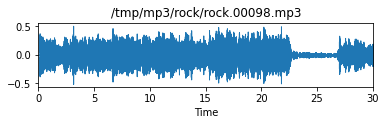

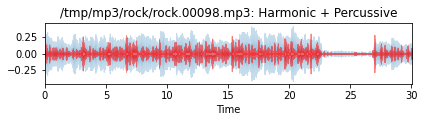

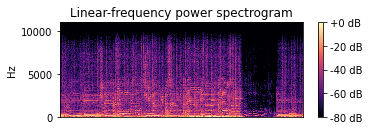

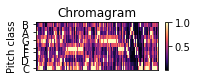

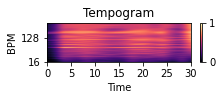

In [3]:
# Before we extract the features, let's plot some information on a demo song, to illustrate what we are doing

import matplotlib.pyplot as plt
from librosa import display
import librosa
import numpy as np


demoSongName = fileNames[1]
demoSongPath = imagePath + demoSongName
#demoSongPath = demoSongPath.replace("\\", "/")
print(demoSongPath)
print ("Showing demo feature extraction on song " + demoSongPath)

y, sr = librosa.load(demoSongPath)

# compute the tempo
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
print ("The song has " + str(tempo) + " beats per minute")

# plot the wave form
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title(demoSongPath)

y_harm, y_perc = librosa.effects.hpss(y)
plt.figure()
plt.subplot(3, 1, 3)
librosa.display.waveplot(y_harm, sr=sr, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5)
plt.title(demoSongPath + ': Harmonic + Percussive')
plt.tight_layout()


# Plot the power spectrum
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Plot Chroma
plt.figure()
C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.subplot(4, 2, 5)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

# Plot tempogram
plt.figure()
plt.subplot(4, 2, 8)
Tgram = librosa.feature.tempogram(y=y, sr=sr)
librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()

plt.show()

In [4]:
# Now we do the actual feature extraction
import datetime
from collections import deque
import warnings

import numpy as np
import scipy.stats.stats as st

warnings.filterwarnings("ignore", message = 'PySoundFile failed. Trying audioread instead.')

# This is a helper function that computes the differences between adjacent array values
def differences(seq):
    iterable = iter(seq)
    prev = next(iterable)
    for element in iterable:
        yield element - prev
        prev = element

# This is a helper function that computes various statistical moments over a series of values, including mean, median, var, min, max, skewness and kurtosis (a total of 7 values)
def statistics(numericList):
    return [np.mean(numericList), np.median(numericList), np.var(numericList), np.float64(st.skew(numericList)), np.float64(st.kurtosis(numericList)), np.min(numericList), np.max(numericList)]



print ("Extracting features using librosa" + " (" + str(datetime.datetime.now()) + ")")

# compute some features based on BPMs, MFCCs, Chroma
data_bpm=[]
data_bpm_statistics=[]
data_mfcc=[]
data_chroma=[]

for indexSample, fileName in enumerate(fileNames):
    # Load the audio as a waveform `y`, store the sampling rate as `sr`
    y, sr = librosa.load(fileName)

    # run the default beat tracker
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    # from this, we simply use the tempo as BPM feature
    data_bpm.append([tempo])

    # Then we compute a few statistics on the beat timings
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    # from the timings, compute the time differences between the beats
    beat_intervals = np.array(deque(differences(beat_times)))

    # And from this, take some statistics
    # There might be a few files where the beat timings are not determined properly; we ignore them, resp. give them 0 values
    if len(beat_intervals) < 1:
        print ("Errors with beat interval in file " + fileName + ", index " + str(indexSample) + ", using 0 values instead")
        data_bpm_statistics.append([tempo, 0, 0, 0, 0, 0, 0, 0])
    else:
        bpm_statisticsVector=[]
        bpm_statisticsVector.append(tempo) # we also include the raw value of tempo
        for stat in statistics(beat_intervals):  # in case the timings are ok, we actually compute the statistics
            bpm_statisticsVector.append(stat) # and append it to the vector, which finally has 1 + 7 features
        data_bpm_statistics.append(bpm_statisticsVector)

    # Next feature are MFCCs; we take 12 coefficients; for each coefficient, we have around 40 values per second
    mfccs=librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
    mfccVector=[]
    for mfccCoefficient in mfccs: # we transform this time series by taking again statistics over the values
        mfccVector.append(statistics(mfccCoefficient))

    # Finally, this vector should have 12 * 7 features
    data_mfcc.append(np.array(mfccVector).flatten())


    # Last feature set - chroma (which is roughly similar to actual notes)
    chroma=librosa.feature.chroma_stft(y=y, sr=sr)
    chromaVector=[]
    for chr in chroma: # similar to before, we get a number of time-series
        chromaVector.append(statistics(chr)) # and we resolve that by taking statistics over the time series
    # Finally, this vector should be be 12 * 7 features
    data_chroma.append(np.array(chromaVector).flatten())

print (".... done" + " (" + str(datetime.datetime.now()) + ")")

# Finally, we do classification
# These are our feature sets; we will use each of them individually to train classifiers
trainingSets = [data_bpm, data_bpm_statistics, data_chroma, data_mfcc ]

Extracting features using librosa (2020-06-10 21:23:29.218589)
Errors with beat interval in file classical/classical.00050.mp3, index 849, using 0 values instead
.... done (2020-06-10 21:32:40.171032)


### Calculation Functions


#### k-NN Calculation

In [5]:
from sklearn import neighbors

def calculate_knn(dataset_name, data, target):
    knn_results = []

    n_neighbors = range(1,10,1)

    for n in n_neighbors:
        knn_classifier = neighbors.KNeighborsClassifier(n)
        description = "N = " + str(n)
        result = calculate_results_cross_validate(dataset_name,
                                                  knn_classifier,
                                                  "knn",
                                                  data,
                                                  target)
        knn_results.append(result)
    return knn_results


#### Bayes Calculation

In [6]:
from sklearn import naive_bayes

def calculate_bayes(dataset_name, data, target):
    bayes_results = []

    classifier = naive_bayes.CategoricalNB()
    result = calculate_results_cross_validate(dataset_name,
                                              classifier,
                                              "bayes",
                                              data,
                                              target)
    bayes_results.append(result)

    return bayes_results

#### Perceptron Calculation

In [7]:
from sklearn import linear_model

def calculate_perceptron(dataset_name, data, target):
    perceptron_results=[]
    classifier = linear_model.Perceptron()
    result = calculate_results_cross_validate(dataset_name,
                                              classifier,
                                              "perceptron",
                                              data,
                                              target)
    perceptron_results.append(result)
    return perceptron_results

#### Decision Tree Calculation

In [8]:
from sklearn.tree import DecisionTreeClassifier

def calculate_decision_tree(dataset_name, data, target):
    # Parameters for the decision tree
    classifiers = [
        DecisionTreeClassifier(),
        DecisionTreeClassifier(max_depth = 5),
        DecisionTreeClassifier(min_samples_leaf = 50)
        ]
    decision_tree_results = []

    for classifier in classifiers:
        result = calculate_results_cross_validate(dataset_name,
                                                  classifier,
                                                  "decision tree",
                                                  data,
                                                  target)
        decision_tree_results.append(result)
    return decision_tree_results


In [9]:
from sklearn.tree import DecisionTreeClassifier

def calculate_decision_tree_pruning_effect(dataset_name, data, target):
    # Parameters for the decision tree

    pruning_sizes = range(1,50,1)
    decision_tree_results = []

    for pruning_size in pruning_sizes:
        classifier = DecisionTreeClassifier(max_depth = pruning_size)
        result = calculate_results_cross_validate(dataset_name,
                                                  classifier,
                                                  "decision tree",
                                                  data,
                                                  target)
        decision_tree_results.append(result)
    return pd.DataFrame(decision_tree_results)

#### Random Forest Calculation

In [10]:
from sklearn.ensemble import RandomForestClassifier

def calculate_random_forest(dataset_name, data, target):

    # Split the data into training and testing sets
    train_X, test_X, train_Y, test_Y = train_test_split(data, target, test_size = 0.33)
    # Parameters for the random forest
    arguments = range(10,200,50)
    random_forest_results = []

    for argument in arguments:
        classifier = RandomForestClassifier(n_estimators = argument)
        classifier.fit(train_X, train_Y)
        test_Y_predicted = classifier.predict(test_X)
        precision = metrics.precision_score(test_Y, test_Y_predicted, average = "micro")
        accuracy = metrics.accuracy_score(test_Y, test_Y_predicted)

        random_forest_results.append(pd.Series({
            'dataset': dataset_name,
            'classifier': "Random Forest",
            'arguments': str(classifier),
            'mean_accuracy': accuracy,
            'mean_precision': precision,
            'mean_recall': "-",
            'accuracy': "-",
            'precision': "-",
            'recall': "-"
        }))

    return random_forest_results

#### SVM Calculation

In [11]:
from sklearn import svm
from sklearn import preprocessing

def calculate_svm(dataset_name, data, target):
    svm_results = []

    classifiers = [
        svm.SVC(max_iter = 10000),
        svm.LinearSVC(max_iter = 10000)
    ]

    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    for classifier in classifiers:
        result = calculate_results_cross_validate(dataset_name,
                                                  classifier,
                                                  "svm",
                                                  data,
                                                  target)
        svm_results.append(result)
    return svm_results

## Calculate Classifiers

In [12]:
### Load Datasets
from sklearn import datasets as sk_datasets

# Iris and Digits
iris = sk_datasets.load_iris()
digits = sk_datasets.load_digits()

datasets = [{'name': 'iris', 'data': iris.data, 'target': iris.target},
            {'name': 'digits', 'data': digits.data, 'target': digits.target},
            {'name': 'data_bpm', 'data': trainingSets[0], 'target': musicTarget},
            {'name': 'data_bpm_statistics', 'data': trainingSets[1], 'target': musicTarget},
            {'name': 'data_chroma', 'data': trainingSets[2], 'target': musicTarget},
            {'name': 'data_mfcc', 'data': trainingSets[3], 'target': musicTarget}]

for dataset in datasets:
    overall_results_dataset = []
    name = dataset['name']
    data = dataset['data']
    target = dataset['target']

    overall_results_dataset.extend(calculate_knn(name, data, target))
    #overall_results_dataset.extend(calculate_bayes(name, data, target))
    overall_results_dataset.extend(calculate_perceptron(name, data, target))
    overall_results_dataset.extend(calculate_decision_tree(name, data, target))
    overall_results_dataset.extend(calculate_random_forest(name, data, target))
    overall_results_dataset.extend(calculate_svm(name, data, target))

    overall_results_dataset = pd.DataFrame(overall_results_dataset)
    dataset['result'] = overall_results_dataset

## Report Results

### Iris Dataset

'iris'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,iris,knn,KNeighborsClassifier(n_neighbors=1),0.960000,0.963434,0.96,m: 0.96 std: 0.024944382578492935,m: 0.9634343434343435 std: 0.023161067713885288,m: 0.96 std: 0.024944382578492984
1,iris,knn,KNeighborsClassifier(n_neighbors=2),0.946667,0.952189,0.946667,m: 0.9466666666666665 std: 0.03399346342395189,m: 0.9521885521885523 std: 0.032235430693337175,m: 0.9466666666666665 std: 0.03399346342395191
2,iris,knn,KNeighborsClassifier(n_neighbors=3),0.966667,0.970707,0.966667,m: 0.9666666666666668 std: 0.02108185106778919,m: 0.9707070707070707 std: 0.017611712903194614,m: 0.9666666666666668 std: 0.021081851067789228
3,iris,knn,KNeighborsClassifier(n_neighbors=4),0.973333,0.975758,0.973333,m: 0.9733333333333334 std: 0.01333333333333333,m: 0.9757575757575758 std: 0.01212121212121211,m: 0.9733333333333334 std: 0.01333333333333333
4,iris,knn,KNeighborsClassifier(),0.973333,0.976768,0.973333,m: 0.9733333333333334 std: 0.02494438257849294,m: 0.9767676767676768 std: 0.021091528300829367,m: 0.9733333333333334 std: 0.024944382578492973
5,iris,knn,KNeighborsClassifier(n_neighbors=6),0.980000,0.981818,0.98,m: 0.9800000000000001 std: 0.016329931618554516,m: 0.9818181818181818 std: 0.014845392380504098,m: 0.9800000000000001 std: 0.016329931618554516
6,iris,knn,KNeighborsClassifier(n_neighbors=7),0.980000,0.981818,0.98,m: 0.9800000000000001 std: 0.016329931618554516,m: 0.9818181818181818 std: 0.014845392380504098,m: 0.9800000000000001 std: 0.016329931618554516
7,iris,knn,KNeighborsClassifier(n_neighbors=8),0.966667,0.967273,0.966667,m: 0.9666666666666668 std: 0.029814239699997188,m: 0.9672727272727272 std: 0.029838869394160458,m: 0.9666666666666666 std: 0.02981423969999724
8,iris,knn,KNeighborsClassifier(n_neighbors=9),0.973333,0.974545,0.973333,m: 0.9733333333333334 std: 0.02494438257849294,m: 0.9745454545454546 std: 0.024663018120455554,m: 0.9733333333333334 std: 0.024944382578492973
9,iris,perceptron,Perceptron(),0.726667,0.766075,0.726667,m: 0.7266666666666667 std: 0.06463573143221775,m: 0.7660749381337617 std: 0.13461727070992252,m: 0.7266666666666667 std: 0.06463573143221772


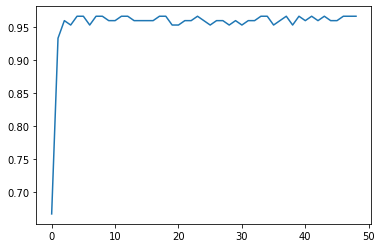

In [20]:
#Data reporting
from IPython.display import display

display(datasets[0]['name'], datasets[0]['result'])

pruning_results = calculate_decision_tree_pruning_effect(datasets[0]['name'], datasets[0]['data'], datasets[0]['target'])
pruning_results['mean_accuracy'].plot.line()

### Digits Dataset

'digits'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,digits,knn,KNeighborsClassifier(n_neighbors=1),0.964393,0.966470,0.964336,m: 0.9643933766635715 std: 0.011838424332891945,m: 0.966469548788538 std: 0.010632112151894059,m: 0.964336033512504 std: 0.011757226426753463
1,digits,knn,KNeighborsClassifier(n_neighbors=2),0.967171,0.968967,0.966957,m: 0.9671711544413494 std: 0.0061807234218177465,m: 0.9689673105288057 std: 0.005663822635776744,m: 0.9669567214273098 std: 0.0060744453248457175
2,digits,knn,KNeighborsClassifier(n_neighbors=3),0.966065,0.967450,0.965924,m: 0.9660646858557721 std: 0.009667874607068043,m: 0.9674502552623923 std: 0.009018588947318053,m: 0.9659241173947055 std: 0.009667378432553301
3,digits,knn,KNeighborsClassifier(n_neighbors=4),0.963841,0.966078,0.963575,m: 0.9638409161250386 std: 0.010945532623198,m: 0.9660776544299914 std: 0.009757692838089959,m: 0.9635748353395412 std: 0.01097966879217311
4,digits,knn,KNeighborsClassifier(),0.962728,0.964711,0.962557,m: 0.9627282575054161 std: 0.011168537355954218,m: 0.9647105099179404 std: 0.010266960336583798,m: 0.9625573220279102 std: 0.011176822445975412
5,digits,knn,KNeighborsClassifier(n_neighbors=6),0.959386,0.961224,0.959176,m: 0.9593856391210152 std: 0.010612016344327235,m: 0.961224271301029 std: 0.009721441327897259,m: 0.9591755116461 std: 0.010552036837323654
6,digits,knn,KNeighborsClassifier(n_neighbors=7),0.959946,0.961718,0.959763,m: 0.9599458372021046 std: 0.015059089584590093,m: 0.9617184051471506 std: 0.013821633585571631,m: 0.9597628132334014 std: 0.015061302477161276
7,digits,knn,KNeighborsClassifier(n_neighbors=8),0.958276,0.960109,0.958079,m: 0.9582760755184154 std: 0.014579790973465996,m: 0.960108921624704 std: 0.013444993062790362,m: 0.9580793398440457 std: 0.014508223803373129
8,digits,knn,KNeighborsClassifier(n_neighbors=9),0.956611,0.958885,0.956381,m: 0.9566109563602601 std: 0.01688704976398654,m: 0.9588846074758639 std: 0.01509933407533814,m: 0.956380927145633 std: 0.01680086257941144
9,digits,perceptron,Perceptron(),0.889850,0.903112,0.889553,m: 0.8898498916744042 std: 0.0372568973027817,m: 0.9031117904416195 std: 0.030180757216644268,m: 0.889553082494259 std: 0.03684074402780773


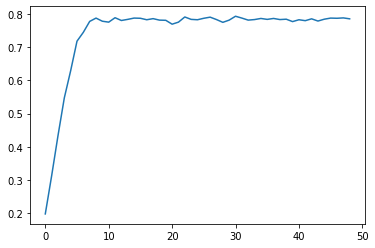

In [21]:
display(datasets[1]['name'], datasets[1]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[1]['name'], datasets[1]['data'], datasets[1]['target'])
pruning_results['mean_accuracy'].plot.line()

### Music Dataset

#### BPM

'data_bpm'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,data_bpm,knn,KNeighborsClassifier(n_neighbors=1),0.134000,0.133095,0.134,m: 0.134 std: 0.017146428199482245,m: 0.1330952448349899 std: 0.049930116437044994,m: 0.13399999999999998 std: 0.017146428199482238
1,data_bpm,knn,KNeighborsClassifier(n_neighbors=2),0.132000,0.139644,0.132,m: 0.132 std: 0.02249444375840399,m: 0.13964411923573997 std: 0.039401919081561904,m: 0.13199999999999998 std: 0.022494443758403978
2,data_bpm,knn,KNeighborsClassifier(n_neighbors=3),0.132000,0.128186,0.132,m: 0.13199999999999998 std: 0.02694438717061496,m: 0.1281862730905893 std: 0.05008144181513227,m: 0.13199999999999998 std: 0.026944387170614956
3,data_bpm,knn,KNeighborsClassifier(n_neighbors=4),0.148000,0.133935,0.148,m: 0.148 std: 0.02135415650406262,m: 0.13393505581559767 std: 0.03570123893093419,m: 0.148 std: 0.021354156504062614
4,data_bpm,knn,KNeighborsClassifier(),0.138000,0.119576,0.138,m: 0.13799999999999998 std: 0.02541653005427767,m: 0.11957592637813456 std: 0.030372703389398677,m: 0.13799999999999998 std: 0.025416530054277672
5,data_bpm,knn,KNeighborsClassifier(n_neighbors=6),0.144000,0.123826,0.144,m: 0.14400000000000002 std: 0.02083266665599966,m: 0.12382600479136126 std: 0.0296389767332519,m: 0.144 std: 0.02083266665599965
6,data_bpm,knn,KNeighborsClassifier(n_neighbors=7),0.142000,0.129624,0.142,m: 0.14200000000000002 std: 0.016,m: 0.12962448395699894 std: 0.034710732638322146,m: 0.14200000000000002 std: 0.015999999999999997
7,data_bpm,knn,KNeighborsClassifier(n_neighbors=8),0.130000,0.099424,0.13,m: 0.13 std: 0.024698178070456944,m: 0.09942391174539228 std: 0.024269595732698594,m: 0.12999999999999998 std: 0.024698178070456926
8,data_bpm,knn,KNeighborsClassifier(n_neighbors=9),0.140000,0.109079,0.14,m: 0.13999999999999999 std: 0.0187082869338697,m: 0.1090788442970152 std: 0.024443057242924754,m: 0.13999999999999999 std: 0.018708286933869705
9,data_bpm,perceptron,Perceptron(),0.100000,0.010000,0.1,m: 0.1 std: 0.0,m: 0.01 std: 0.0,m: 0.1 std: 0.0


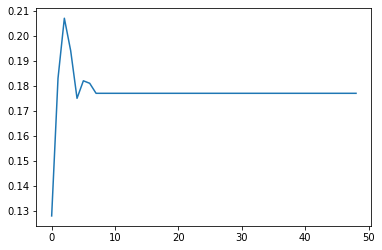

In [22]:
display(datasets[2]['name'], datasets[2]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[2]['name'], datasets[2]['data'], datasets[2]['target'])
pruning_results['mean_accuracy'].plot.line()

#### BPM Statistics

'data_bpm_statistics'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=1),0.178000,0.173767,0.178,m: 0.17800000000000002 std: 0.04118252056394801,m: 0.17376741970582327 std: 0.036023601761846914,m: 0.178 std: 0.04118252056394799
1,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=2),0.138000,0.133715,0.138,m: 0.13799999999999998 std: 0.026381811916545837,m: 0.1337151397993633 std: 0.024109830958204244,m: 0.13799999999999998 std: 0.026381811916545837
2,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=3),0.140000,0.153674,0.14,m: 0.13999999999999999 std: 0.03860051813123756,m: 0.15367377268569857 std: 0.05150245283865464,m: 0.13999999999999999 std: 0.03860051813123756
3,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=4),0.167000,0.180485,0.167,m: 0.16699999999999998 std: 0.025999999999999995,m: 0.18048488087861791 std: 0.034628739473841944,m: 0.16699999999999998 std: 0.026000000000000002
4,data_bpm_statistics,knn,KNeighborsClassifier(),0.165000,0.177439,0.165,m: 0.16499999999999998 std: 0.03162277660168379,m: 0.1774385807725894 std: 0.03591252241507328,m: 0.16499999999999998 std: 0.031622776601683784
5,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=6),0.160000,0.164632,0.16,m: 0.16 std: 0.03687817782917155,m: 0.16463188131357623 std: 0.04564480654130463,m: 0.16 std: 0.03687817782917154
6,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=7),0.149000,0.151005,0.149,m: 0.149 std: 0.032310988842807024,m: 0.15100503776250215 std: 0.04092169861213397,m: 0.14899999999999997 std: 0.03231098884280702
7,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=8),0.154000,0.157676,0.154,m: 0.154 std: 0.03733630940518894,m: 0.15767623487441648 std: 0.052027875458418915,m: 0.15400000000000003 std: 0.037336309405188936
8,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=9),0.149000,0.145652,0.149,m: 0.149 std: 0.03337663853655727,m: 0.14565183823246938 std: 0.040774539240353666,m: 0.149 std: 0.03337663853655727
9,data_bpm_statistics,perceptron,Perceptron(),0.103000,0.019136,0.103,m: 0.10300000000000001 std: 0.006782329983125268,m: 0.01913565471960827 std: 0.004814050128224503,m: 0.10300000000000001 std: 0.0067823299831252645


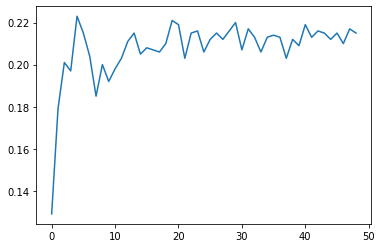

In [23]:
display(datasets[3]['name'], datasets[3]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[3]['name'], datasets[3]['data'], datasets[3]['target'])
pruning_results['mean_accuracy'].plot.line()

#### Chroma

'data_chroma'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,data_chroma,knn,KNeighborsClassifier(n_neighbors=1),0.307000,0.308005,0.307,m: 0.307 std: 0.019899748742132416,m: 0.3080048236025353 std: 0.02220916489061227,m: 0.30699999999999994 std: 0.01989974874213241
1,data_chroma,knn,KNeighborsClassifier(n_neighbors=2),0.310000,0.316162,0.31,m: 0.31 std: 0.026832815729997468,m: 0.31616150116887465 std: 0.05999375578145055,m: 0.31000000000000005 std: 0.02683281572999747
2,data_chroma,knn,KNeighborsClassifier(n_neighbors=3),0.310000,0.319674,0.31,m: 0.31 std: 0.026267851073127395,m: 0.31967440294641614 std: 0.026859914568178926,m: 0.30999999999999994 std: 0.026267851073127405
3,data_chroma,knn,KNeighborsClassifier(n_neighbors=4),0.325000,0.325734,0.325,m: 0.325 std: 0.028809720581775857,m: 0.3257343728604093 std: 0.01832661163757916,m: 0.325 std: 0.028809720581775857
4,data_chroma,knn,KNeighborsClassifier(),0.328000,0.324824,0.328,m: 0.32799999999999996 std: 0.020880613017821098,m: 0.32482377983108723 std: 0.02080476464509703,m: 0.328 std: 0.020880613017821077
5,data_chroma,knn,KNeighborsClassifier(n_neighbors=6),0.340000,0.337331,0.34,m: 0.33999999999999997 std: 0.033166247903554,m: 0.3373306080103687 std: 0.030417025521870235,m: 0.33999999999999997 std: 0.03316624790355399
6,data_chroma,knn,KNeighborsClassifier(n_neighbors=7),0.332000,0.323215,0.332,m: 0.33199999999999996 std: 0.027856776554368242,m: 0.32321466270189647 std: 0.026764701956724146,m: 0.33199999999999996 std: 0.027856776554368242
7,data_chroma,knn,KNeighborsClassifier(n_neighbors=8),0.335000,0.324445,0.335,m: 0.335 std: 0.03146426544510455,m: 0.32444484953141706 std: 0.01994329938378952,m: 0.335 std: 0.03146426544510453
8,data_chroma,knn,KNeighborsClassifier(n_neighbors=9),0.333000,0.319738,0.333,m: 0.333 std: 0.03487119154832538,m: 0.3197375555776478 std: 0.02488260971727399,m: 0.333 std: 0.034871191548325374
9,data_chroma,perceptron,Perceptron(),0.231000,0.254747,0.231,m: 0.23099999999999996 std: 0.055982140009113626,m: 0.25474749345422004 std: 0.057043450391375504,m: 0.23099999999999996 std: 0.05598214000911363


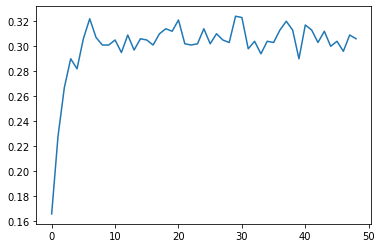

In [24]:
display(datasets[4]['name'], datasets[4]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[4]['name'], datasets[4]['data'], datasets[4]['target'])
pruning_results['mean_accuracy'].plot.line()

#### MFCC

'data_mfcc'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,data_mfcc,knn,KNeighborsClassifier(n_neighbors=1),0.319000,0.346639,0.319,m: 0.319 std: 0.04199999999999999,m: 0.3466391133965758 std: 0.04460203197145104,m: 0.319 std: 0.04199999999999998
1,data_mfcc,knn,KNeighborsClassifier(n_neighbors=2),0.311000,0.337969,0.311,m: 0.31100000000000005 std: 0.033970575502926044,m: 0.3379689050404274 std: 0.04557085367206833,m: 0.31099999999999994 std: 0.03397057550292604
2,data_mfcc,knn,KNeighborsClassifier(n_neighbors=3),0.325000,0.359320,0.325,m: 0.32499999999999996 std: 0.02428991560298224,m: 0.35932029681793215 std: 0.02668603943635205,m: 0.325 std: 0.024289915602982236
3,data_mfcc,knn,KNeighborsClassifier(n_neighbors=4),0.321000,0.338612,0.321,m: 0.321 std: 0.03666060555964671,m: 0.3386118452416282 std: 0.03347485271320054,m: 0.321 std: 0.03666060555964671
4,data_mfcc,knn,KNeighborsClassifier(),0.325000,0.343799,0.325,m: 0.325 std: 0.03646916505762095,m: 0.34379852010792245 std: 0.03260042563779909,m: 0.325 std: 0.03646916505762094
5,data_mfcc,knn,KNeighborsClassifier(n_neighbors=6),0.330000,0.341977,0.33,m: 0.32999999999999996 std: 0.04764451699828638,m: 0.34197742926224733 std: 0.0436928659835618,m: 0.32999999999999996 std: 0.047644516998286375
6,data_mfcc,knn,KNeighborsClassifier(n_neighbors=7),0.332000,0.343382,0.332,m: 0.33199999999999996 std: 0.033105890714493706,m: 0.3433822620055794 std: 0.03000526530120327,m: 0.332 std: 0.033105890714493685
7,data_mfcc,knn,KNeighborsClassifier(n_neighbors=8),0.332000,0.349196,0.332,m: 0.33199999999999996 std: 0.0331058907144937,m: 0.3491957134344011 std: 0.04118405747504487,m: 0.33199999999999996 std: 0.03310589071449373
8,data_mfcc,knn,KNeighborsClassifier(n_neighbors=9),0.317000,0.327029,0.317,m: 0.317 std: 0.045343136195018535,m: 0.3270288351417535 std: 0.04351904792762874,m: 0.317 std: 0.045343136195018535
9,data_mfcc,perceptron,Perceptron(),0.229000,0.271794,0.229,m: 0.229 std: 0.03878143885933062,m: 0.2717937106607759 std: 0.04639412218691525,m: 0.229 std: 0.03878143885933062


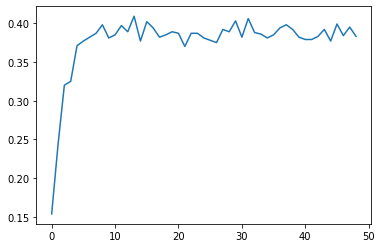

In [25]:
display(datasets[5]['name'], datasets[5]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[5]['name'], datasets[5]['data'], datasets[5]['target'])
pruning_results['mean_accuracy'].plot.line()